In [256]:
# Ensure interactive plotting works in Google Colab
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

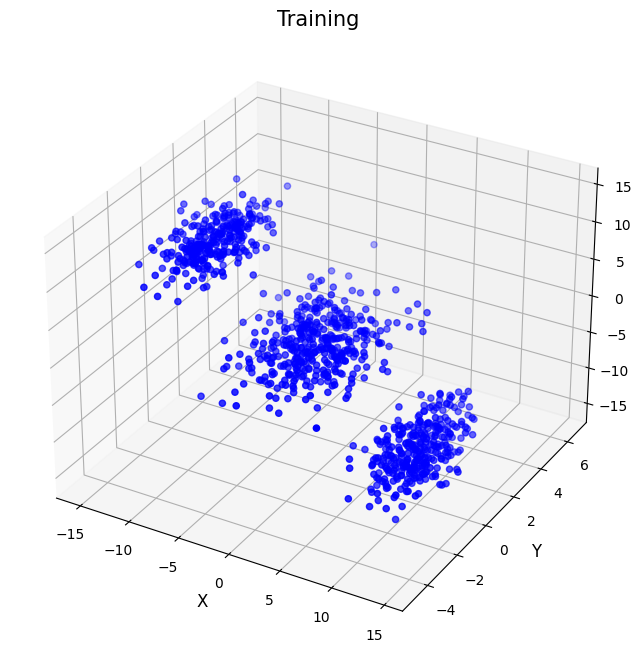

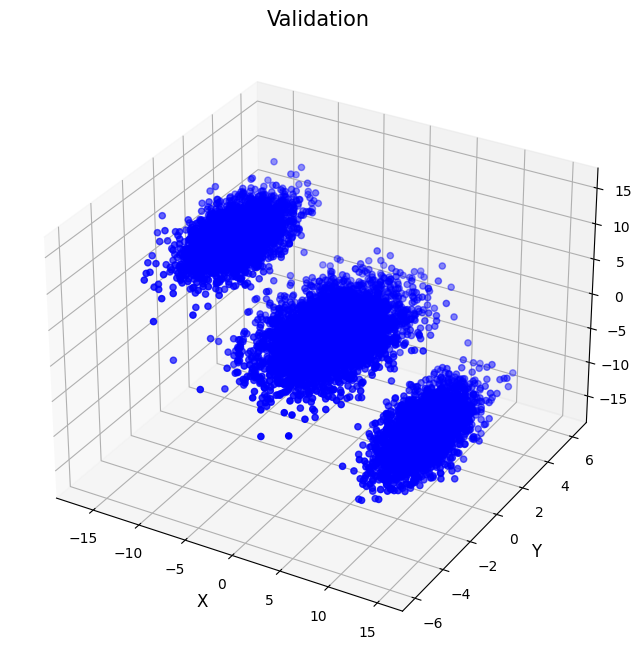

In [257]:
def generate_q2_data(N, dataset_name):
    """
    Generate training or validation data using a GMM and plot the data.

    Args:
        N (int): Number of data samples to generate.
        dataset_name (str): Name of the dataset (e.g., 'Training', 'Validation').

    Returns:
        tuple: Features (X) and target values (y).
    """
    # Define GMM parameters
    gmm_pdf = {
        'priors': np.array([0.3, 0.4, 0.3]),
        'mu': np.array([[-10, 0, 10], [0, 0, 0], [10, 0, -10]]),
        'Sigma': np.array([
            [[3, 0, 0], [0, 2, 0], [0, 0, 2]],
            [[7, 0, 0], [0, 3, 0], [0, 0, 3]],
            [[2, 0, 0], [0, 2, 0], [0, 0, 4]]
        ])
    }

    # Generate GMM data
    X = generate_gmm_data(N, gmm_pdf)

    # Plot the data in 3D
    plot3(X[0, :], X[1, :], X[2, :], dataset_name)

    # Return the features (X) and target values (y)
    return X[0:2, :].T, X[2, :]

def generate_gmm_data(N, gmm_pdf):
    """
    Generate data samples from a Gaussian Mixture Model (GMM).

    Args:
        N (int): Number of samples to generate.
        gmm_pdf (dict): GMM parameters (priors, means, covariances).

    Returns:
        np.ndarray: Generated samples of shape (3, N).
    """
    # Randomly assign samples to components based on priors
    u = np.random.rand(N)
    thresholds = np.cumsum(gmm_pdf['priors'])
    thresholds = np.insert(thresholds, 0, 0)

    # Initialize the sample matrix
    X = np.zeros((3, N))

    # Generate samples for each component
    for k in range(1, len(thresholds)):
        indices = np.argwhere((u >= thresholds[k - 1]) & (u < thresholds[k])).flatten()
        X[:, indices] = np.random.multivariate_normal(
            gmm_pdf['mu'][k - 1], gmm_pdf['Sigma'][k - 1], size=len(indices)
        ).T

    return X

def plot3(x, y, z, title):
    """
    Plot a 3D scatter plot of the generated data with an increased figure size.

    Args:
        x (np.ndarray): X-coordinates.
        y (np.ndarray): Y-coordinates.
        z (np.ndarray): Z-coordinates.
        title (str): Title of the plot.
    """
    # Create the 3D plot with a larger figure size (width, height)
    fig = plt.figure(figsize=(12, 8))  # Properly using a tuple for figsize
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, marker='o', color='b')

    # Set labels and title with adjusted font sizes
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_zlabel('Z', fontsize=12)
    ax.set_title(title, fontsize=15)

    plt.show()

# Example usage to generate training and validation datasets
X_train, y_train = generate_q2_data(1000, "Training")
X_valid, y_valid = generate_q2_data(10000, "Validation")


In [258]:
def create_prediction_score_grid(bounds_X, bounds_Y, prediction_function, phi=None, num_coords=100):
    """
    Generate a grid of prediction scores over the specified x-y bounds.
    """
    # Create a meshgrid within the specified bounds
    xx, yy = np.meshgrid(
        np.linspace(bounds_X[0], bounds_X[1], num_coords),
        np.linspace(bounds_Y[0], bounds_Y[1], num_coords)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]  # Flatten the grid coordinates

    # Apply the phi transformation if provided
    if phi is not None:
        grid = phi.transform(grid)

    # Apply the prediction function to each point on the grid
    Z = np.array([prediction_function(point) for point in grid])

    # Reshape Z to match the shape of the meshgrid
    Z = Z.reshape(xx.shape)
    return xx, yy, Z

In [259]:
def ml_solution(X, y):
    """Compute the ML parameter solution using the normal equation."""
    try:
        return np.linalg.inv(X.T @ X) @ X.T @ y
    except np.linalg.LinAlgError:
        return np.linalg.pinv(X.T @ X) @ X.T @ y


In [260]:
def map_solution(X, y, gamma=0.1):
    """Compute the MAP solution with regularization."""
    I = np.eye(X.shape[1])
    return np.linalg.pinv(X.T @ X + gamma * I) @ X.T @ y

In [261]:
def mean_squared_error(y_preds, y_true):
    """Compute the Mean Squared Error (MSE)."""
    error = y_preds - y_true
    return np.mean(error ** 2)


MSE on Validation set for ML parameter estimator: 6.843


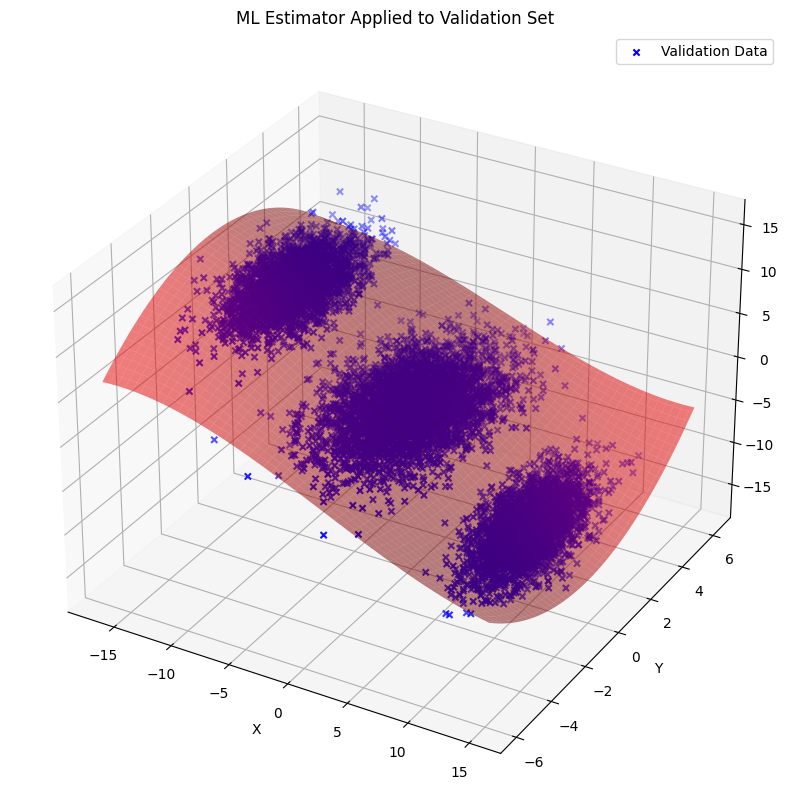

In [262]:
# Apply cubic transformation
phi = PolynomialFeatures(degree=3)
X_train_cubic = phi.fit_transform(X_train)

# Compute ML solution
theta_mle = ml_solution(X_train_cubic, y_train)

# Transform validation data
X_valid_cubic = phi.transform(X_valid)
y_pred_mle = X_valid_cubic @ theta_mle

# Compute and print MSE
mse_mle = mean_squared_error(y_pred_mle, y_valid)
print(f"MSE on Validation set for ML parameter estimator: {mse_mle:.3f}")

# Plotting the ML Estimator
fig_mle = plt.figure(figsize=(10, 10))
ax_mle = fig_mle.add_subplot(111, projection='3d')

# Scatter plot of validation data
ax_mle.scatter(X_valid[:, 0], X_valid[:, 1], y_valid, color='b', marker='x', label='Validation Data')

# Plot the fitted surface
xx, yy, Z = create_prediction_score_grid(
    (np.min(X_valid[:, 0]), np.max(X_valid[:, 0])),
    (np.min(X_valid[:, 1]), np.max(X_valid[:, 1])),
    lambda point: phi.transform([point]) @ theta_mle
)
ax_mle.plot_surface(xx, yy, Z, color='red', alpha=0.5)

# Labeling
ax_mle.set_xlabel('X')
ax_mle.set_ylabel('Y')
ax_mle.set_zlabel('Z')
ax_mle.set_title('ML Estimator Applied to Validation Set')
ax_mle.legend()

plt.show()

Best MSE on Validation set for MAP parameter estimator with gamma=3.12525: 6.836


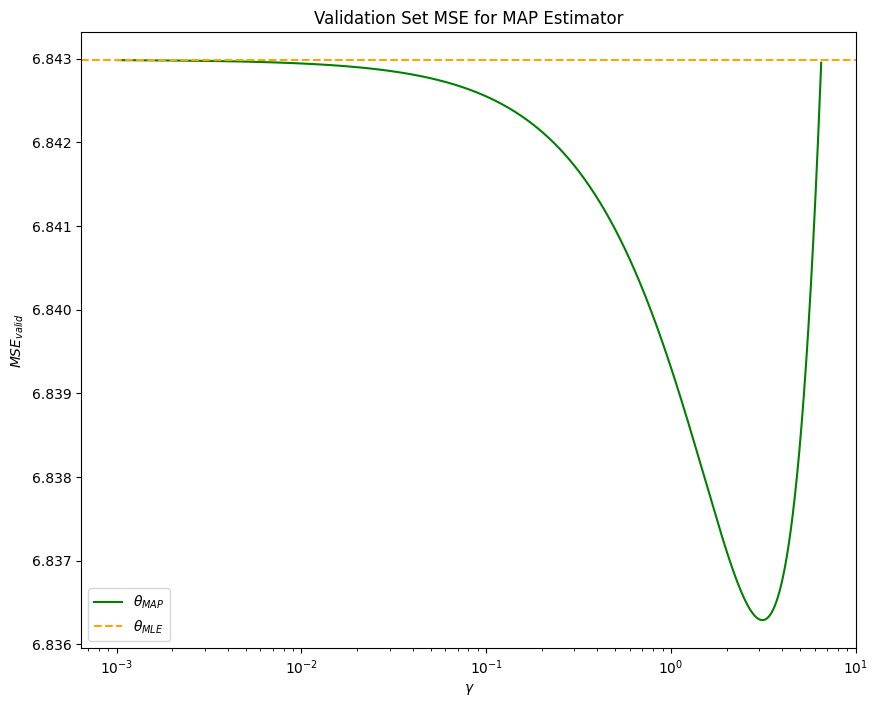

In [265]:
# Scale the original data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Apply polynomial features after scaling
X_train_cubic = phi.fit_transform(X_train_scaled)
X_valid_cubic = phi.transform(X_valid_scaled)

# Use geomspace to generate 1000 gamma values on a log scale from 10^-7 to 10^7
num_gammas = 10000
gammas = np.geomspace(1e-3, 6.5, num=num_gammas)

# Initialize an array to store MSE values for different gamma values
mse_values_map = np.empty(num_gammas)

# Iterate through gamma values and compute MSE for MAP parameter estimator
for i, gamma_value in enumerate(gammas):
    # Compute MAP parameter solution
    theta_map = map_solution(X_train_cubic, y_train, gamma_value)

    # Make predictions on the validation set
    y_pred_map = X_valid_cubic @ theta_map

    # Calculate and store Mean Squared Error (MSE)
    mse_values_map[i] = mean_squared_error(y_pred_map, y_valid)

# Find the gamma value corresponding to the minimum MSE
best_gamma_map = gammas[np.argmin(mse_values_map)]

# Print the best MSE and corresponding gamma
print(f"Best MSE on Validation set for MAP parameter estimator with gamma={best_gamma_map:.5f}: {np.min(mse_values_map):.3f}")

# Create a plot showing the MSE vs regularization parameter gamma
fig_map, ax_map = plt.subplots(figsize=(10, 8))

# Plot the MSE values for different gamma values
ax_map.plot(gammas, mse_values_map, color='green', label=r"$\theta_{MAP}$")

# Draw a horizontal line representing the MSE for the ML parameter estimator
ax_map.axhline(y=mse_mle, color='orange', linestyle='--', label=r"$\theta_{MLE}$")

# Set the x-axis to a logarithmic scale
ax_map.set_xscale('log')

# Set labels and title
ax_map.set_xlabel(r"$\gamma$")
ax_map.set_ylabel(r"$MSE_{valid}$")
ax_map.set_title("Validation Set MSE for MAP Estimator")

# Add legend
ax_map.legend()

# Show the plot
plt.show()